# Install


In [2]:
import os
!git clone https://github.com/TensorSpeech/TensorFlowTTS
os.chdir("TensorFlowTTS")
!pip install  .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

fatal: destination path 'TensorFlowTTS' already exists and is not an empty directory.
Processing /content/TensorFlowTTS
  Created wheel for TensorFlowTTS: filename=TensorFlowTTS-0.0-cp36-none-any.whl size=112618 sha256=5c504c34df66dd45cf649c81e8f62cc37f2c6ea71dfadde6a88647addf140530
  Stored in directory: /tmp/pip-ephem-wheel-cache-xawlic0l/wheels/53/fa/a5/6da6cd434ed077f9027135e4143d7acc9e07a34e6aaebcf476
Successfully built TensorFlowTTS
  Found existing installation: TensorFlowTTS 0.0
    Uninstalling TensorFlowTTS-0.0:
      Successfully uninstalled TensorFlowTTS-0.0


# Download pretrained feature generation model


In [4]:
print("Downloading FastSpeech2 model...")
!gdown --id {"1EhMD20uAFlKsii1lMnlkrsenVTFKM0ld"} -O fastspeech2-150k.h5
!gdown --id {"1wnbIgjTI2iUsCyVJ37ar9CS8-aEjVEee"} -O fastspeech2_config.yml

Downloading...
From: https://drive.google.com/uc?id=1EhMD20uAFlKsii1lMnlkrsenVTFKM0ld
To: /content/fastspeech2-150k.h5
125MB [00:00, 242MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wnbIgjTI2iUsCyVJ37ar9CS8-aEjVEee
To: /content/fastspeech2_config.yml
100% 1.67k/1.67k [00:00<00:00, 1.91MB/s]


# Download pretrained Vocoder model


## MelGAN + STFT Loss


In [5]:
print("Downloading MelGAN-STFT model...")
!gdown --id {"1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys"} -O melgan.stft-2M.h5
!gdown --id {"1OqdrcHJvtXwNasEZP7KXZwtGUDXMKNkg"} -O melgan.stft_config.yml

Downloading...
From: https://drive.google.com/uc?id=1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys
To: /content/melgan.stft-2M.h5
17.1MB [00:00, 41.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OqdrcHJvtXwNasEZP7KXZwtGUDXMKNkg
To: /content/melgan.stft_config.yml
100% 1.77k/1.77k [00:00<00:00, 3.06MB/s]


# Load Model


In [6]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import AutoProcessor

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [7]:
fastspeech2_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/fastspeech2/conf/fastspeech2.v1.yaml')
fastspeech2 = TFAutoModel.from_pretrained(
    config=fastspeech2_config,
    pretrained_path="fastspeech2-150k.h5",
    name="fastspeech2"
)

In [13]:
melgan_stft_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/melgan.stft/conf/melgan.stft.v1.yaml')
melgan_stft = TFAutoModel.from_pretrained(
    config=melgan_stft_config,
    pretrained_path="melgan.stft-2M.h5",
    name="melgan_stft"
)

## Inference
- The first time model run inference will very slow cause by @tf.function.

In [8]:
print("Downloading ljspeech_mapper.json ...")
!gdown --id {"1YBaDdMlhTXxsKrH7mZwDu-2aODq5fr5e"} -O ljspeech_mapper.json

Downloading...
From: https://drive.google.com/uc?id=1YBaDdMlhTXxsKrH7mZwDu-2aODq5fr5e
To: /content/ljspeech_mapper.json
100% 3.57k/3.57k [00:00<00:00, 6.56MB/s]


In [9]:
processor = AutoProcessor.from_pretrained(pretrained_path="./ljspeech_mapper.json")

In [10]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH":
    mel_before, mel_outputs, duration_outputs = text2mel_model.inference(
        input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MELGAN" or vocoder_name == "MELGAN-STFT":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  elif vocoder_name == "MB-MELGAN":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MELGAN, MELGAN-STFT and MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [16]:
input_text = "We decided to develop a chatbot with text to speech."

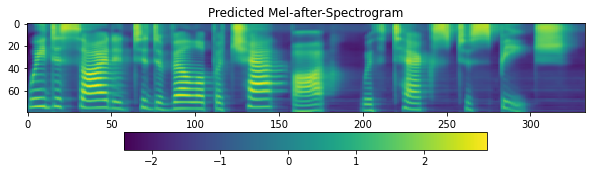

In [18]:
mels, audios = do_synthesis(input_text, fastspeech2, melgan_stft, "FASTSPEECH2", "MELGAN-STFT")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)